In [1]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_lognoise'
run_name = 'sarsa0'
source_dir = '../data/'+system_name+'/'+run_name+'/'
data_dir = '../data/'+system_name+'/'+run_name+'_eval/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Evaluate the 3d kite

In [2]:
# READING THE ENVIRONMENTAL PARAMETERS
env_params = ut.read_params(source_dir+'param_env.txt')
print(env_params)

{'int_steps': 0.001, 'ep_length': 200.0, 'decision_time': 0.25, 'init_theta': 0.7853981633974483, 'init_dtheta': 0.0, 'init_phi': 0.0, 'init_dphi': 0.0, 'alphas': array([ 6.,  8., 10., 12., 14., 16., 18., 20.]), 'CL_alphas': array([0.65, 0.75, 0.82, 0.9 , 1.  , 1.08, 1.1 , 1.05]), 'CD_alphas': array([0.05, 0.07, 0.09, 0.1 , 0.13, 0.18, 0.18, 0.21]), 'init_alpha': 7.0, 'banks': array([-0.26179939, -0.20943951, -0.15707963, -0.10471976, -0.05235988,
        0.        ,  0.05235988,  0.10471976,  0.15707963,  0.20943951,
        0.26179939]), 'init_bank': 5.0, 'beta_bins': array([-3.14159265, -2.6927937 , -2.24399475, -1.7951958 , -1.34639685,
       -0.8975979 , -0.44879895,  0.        ,  0.44879895,  0.8975979 ,
        1.34639685,  1.7951958 ,  2.24399475,  2.6927937 ,  3.14159265]), 'wind_type': 'lognoise', 'vr': 2.4, 'z0': 0.1, 'std': array([1.5, 0.1, 0.1])}


In [3]:
# WRITING THE EVALUATION PARAMETERS
params = dict()
params['alg_type'] = 'eval'
params['policy_path'] = source_dir+'/best_policy.txt'
params['ev_time'] = 500 # sec
params['n_steps'] = params['ev_time']/float(env_params['decision_time'])+1
params['traj_points'] = params['n_steps']
params['gamma'] = 1
ut.write_params(params, data_dir, 'param_alg.txt')

env_params['ep_length'] = params['ev_time']-1
ut.write_params(env_params, data_dir, 'param_env.txt')

In [17]:
p = subprocess.Popen(["./run.exe", system_name, run_name+'_eval'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(p.stderr.read().decode('utf-8'))

In [18]:
f = open(data_dir + "ev_states.txt", "r")
st_traj = []
st_labels = f.readline().split()
for line in f.readlines():
    st_traj.append(line.split())
st_traj = np.array(st_traj, dtype='float')
#st_traj = np.loadtxt(data_dir + system_name + '/' + run_name + "/ev_states.txt", dtype='float')

traj_x=st_traj[:,0]
traj_y=st_traj[:,1]
traj_z=st_traj[:,2]

In [19]:
xs = np.linspace(0, params['ev_time'], num=len(st_traj[:,0]))

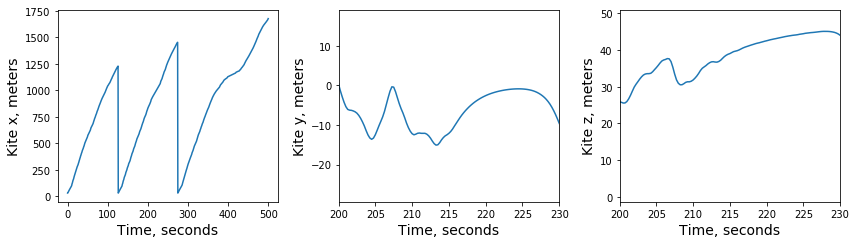

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))

ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Kite x, meters', fontsize=14)
ax1.plot(xs, traj_x)

ax2.set_xlim([200,230])
ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Kite y, meters', fontsize=14)
ax2.plot(xs, traj_y)

ax3.set_xlim([200,230])
ax3.set_xlabel('Time, seconds', fontsize=14)
ax3.set_ylabel('Kite z, meters', fontsize=14)
ax3.plot(xs, traj_z)

plt.tight_layout()
#plt.savefig(plot_dir+"eval_traj.png", dpi=200)

In [21]:
aggr_s_traj, labels = ut.read_traj(data_dir+'ev_aggr_st.txt')
aggr_s_i_traj = np.array(aggr_s_traj[:,0], dtype=int)

In [15]:
beta_list = []
for i in range(len(env_params['beta_bins'])-1):
    beta_list.append((env_params['beta_bins'][i] + env_params['beta_bins'][i+1])/2.0)

In [16]:
def aggr_state_index_translator(index, n_betas, n_banks):
    beta = index % n_betas
    rest = index // n_betas
    bank = rest % n_banks
    alpha = rest // n_banks
    return beta, bank, alpha

In [18]:
beta_i, bank_i, alpha_i = aggr_state_index_translator(aggr_s_i_traj, len(env_params['beta_bins'])-1, len(env_params['banks']))
alphas = np.take(env_params['alphas'], alpha_i)
banks = np.take(env_params['banks'], bank_i)
betas = np.take(beta_list, beta_i)

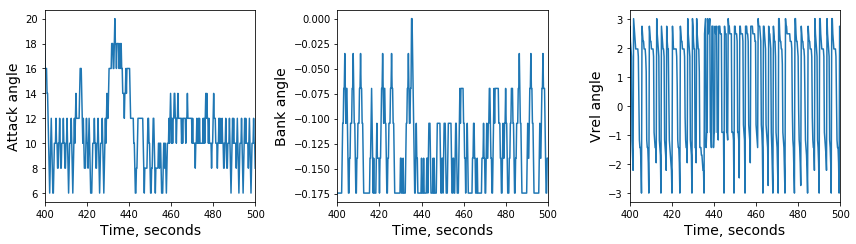

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))
x_wind = [400,500]

ax1.set_xlabel('Time, seconds', fontsize=14)
ax1.set_ylabel('Attack angle', fontsize=14)
ax1.set_xlim(x_wind)
ax1.plot(xs, alphas)

ax2.set_xlabel('Time, seconds', fontsize=14)
ax2.set_ylabel('Bank angle', fontsize=14)
ax2.set_xlim(x_wind)
ax2.plot(xs, banks)

ax3.set_xlabel('Time, seconds', fontsize=14)
ax3.set_ylabel('Vrel angle', fontsize=14)
ax3.set_xlim(x_wind)
ax3.plot(xs, betas)

plt.tight_layout()

In [20]:
def bins_from_list(l):
    bins = np.array([(l[i] + l[i+1])/2 for i in range(len(l)-1)])
    bins = np.append(2*l[0] - bins[0], bins)
    bins = np.append(bins, 2*l[-1] - bins[-1])
    return bins

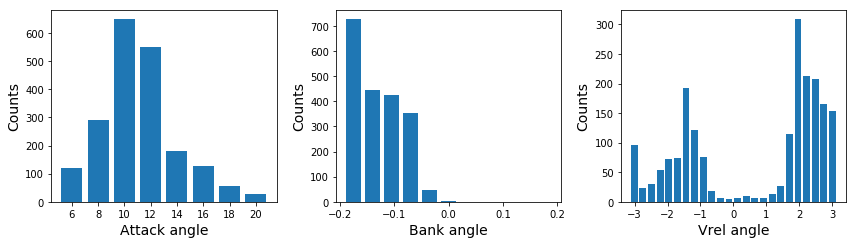

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3.5))

ax1.set_ylabel('Counts', fontsize=14)
ax1.set_xlabel('Attack angle', fontsize=14)
bins = bins_from_list(env_params['alphas'])
ax1.set_xticks(env_params['alphas'])
ax1.hist(alphas, bins=bins, align='mid', rwidth=0.8)

ax2.set_ylabel('Counts', fontsize=14)
ax2.set_xlabel('Bank angle', fontsize=14)
bins = bins_from_list(env_params['banks'])
#ax2.set_xticks(env_params['banks'])
ax2.hist(banks, bins=bins, align='mid', rwidth=0.8)

ax3.set_ylabel('Counts', fontsize=14)
ax3.set_xlabel('Vrel angle', fontsize=14)
bins = bins_from_list(beta_list)
#ax2.set_xticks(env_params['banks'])
ax3.hist(betas, bins=bins, align='mid', rwidth=0.8)

plt.tight_layout()
plt.savefig(plot_dir+"aggr_states.png", dpi=200)

In [5]:
aggr_state_index_translator(1440, 24, 11)

(0, 5, 5)

In [131]:
bins

array([ 6., 10., 13., 15., 17., 19., 21.])